In [3]:
from numpy import load
import numpy as np
import sys
sys.path.append(r'D:\Project\src\Enviroment')
from cvxopt import solvers,matrix
solvers.options['maxiters'] = 30
from env import *
from utils import *
from risks import *
from decoders import *
from cvx import *

def find_average(values,timestep,lookback):
    
    values_first = values[:,timestep-lookback:timestep]
    values_later = values[:,timestep-lookback+1:timestep+1]
    
    returns = (values_later - values_first)/values_first
    
    mean = np.mean(returns,axis = 1)
    
    return mean

long = np.load(r'D:\Project\src\Test_Policies\final_policy\long.npy')
short = np.load(r'D:\Project\src\Test_Policies\final_policy\short.npy')
spy = pd.read_csv(r'D:\Project\src\Enviroment\Data\SPY.csv').Close

In [2]:
def experiment(R,start,end):
    env = Enviroment(start = start, end = end,weights=True,tc=0.1)
    port = [0.0 for _ in range(29)]

    for day in range(start,end):

        if bool(day_names_signals[day]):
            sigma = sharpe(env.values,env.timestep,30)
            P = matrix(sigma)
            q = matrix([0.0 for _ in range(29)])

            A = matrix([1.0 for _ in range(29)]).trans()
            b = matrix(1.0)

            eye = -np.eye(29)
            returns = find_average(env.values,env.timestep,30)
            G = matrix(np.vstack([eye,returns]))
            h = matrix([0.0 for _ in range(29)] + [-R])

            solvers.options['show_progress'] = False

            #solution = solvers.qp(P,q,G,h,A,b)
            try:
                solution = solvers.qp(P,q,G,h,A,b)

                sol = []
                for i in solution['x']:
                    if i<0.001:
                        sol.append(0)
                    else:
                        sol.append(i)
                port = sol
            except:
                pass

            port = env.step(port)

        else:
            port = env.step(port)
            
    env.step([0 for _ in range(29)])

    return env

marko = experiment(0.00385,1750,2850)

In [3]:
c1 = 1
c3 = 1 - c1

env = Enviroment(start = 1750, end = 2850,weights = True,tc=0.1)

port = [0 for _ in range(29)]
for day in range(1750,2850):

    is_Friday = day_names_signals[day] == 1
            
    ssignals = list(long[day-1750,:])
    lsignals = list(short[day-1750,:])

    old_p = port
    signals,port = decoder(ssignals,lsignals,port)
    
    if is_Friday:                    
        sigma = sharpe(env.values,env.timestep,30)
        try:
            port = quadratic(sigma,port,signals,c1,-c3)
            port = [i if abs(i) > 1e-3 else 0 for i in port]
        except:  pass
        port = env.step(port)
    else:
        port = env.step(port)

_ = env.step([0 for _ in range(29)])

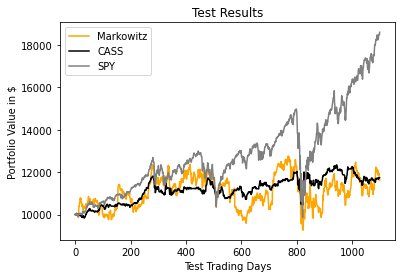

In [4]:
import matplotlib.pyplot as plt
plt.plot(range(1100),marko.record[1750:2850],color = 'orange', label = 'Markowitz')
plt.plot(range(1100),env.record[1750:2850],color = 'black', label = 'CASS')
plt.plot(range(1100),[i*10000/spy[1750] for i in spy[1750:2850]], color = 'grey', label = 'SPY')
plt.xlabel('Test Trading Days')
plt.ylabel('Portfolio Value in $')
plt.title('Test Results')
plt.legend()
plt.show()

In [5]:
print(f'Total tc for Markowitz model are {int(marko.total_tc)}$.')
print(f'and for CASS are {int(env.total_tc)}$.')

Total tc for Markowitz model are 2721$.
and for CASS are 2848$.


In [6]:
marko.valuation

11531.132861093525

In [7]:
env.valuation

11713.791712884913

In [8]:
import matplotlib.pyplot as plt

In [9]:
cass = env.record
cass = np.diff(cass[1750:2850])

mark = marko.record
mark = np.diff(mark[1750:2850])

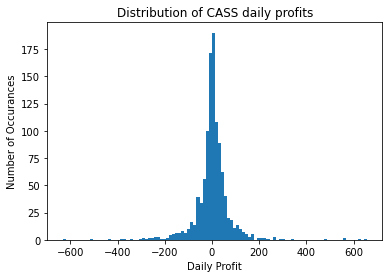

In [10]:
plt.hist(cass,100)
plt.title('Distribution of CASS daily profits')
plt.xlabel('Daily Profit')
plt.ylabel('Number of Occurances')
plt.show()

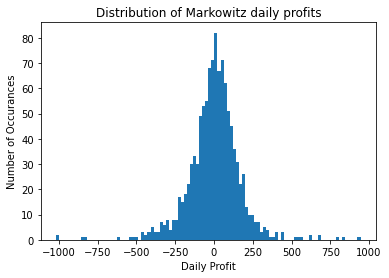

In [11]:
plt.hist(mark,100)
plt.title('Distribution of Markowitz daily profits')
plt.xlabel('Daily Profit')
plt.ylabel('Number of Occurances')
plt.show()

In [12]:
print(f'The Markowitz model has an average daily profit {round(np.mean(mark),2)}$ and std {round(np.std(mark),2)}.')
print(f'The CASS model has an average daily profit {round(np.mean(cass),2)}$ and std {round(np.std(cass),2)}.')

The Markowitz model has an average daily profit 1.48$ and std 167.49.
The CASS model has an average daily profit 1.58$ and std 83.07.


In [13]:
data = np.zeros([4,1100])
for day,number in zip(range(1750,2851),range(1100)):
    
    total_valuation = marko.record[day]
    
    valuation = marko.stonks[:,day]*marko.closes[:,day]
    cash = (total_valuation - np.sum(valuation))
    top_three = np.sort(valuation)[-3:]
    
    data[0,number] = cash/total_valuation
    data[1:4,number] = top_three/total_valuation

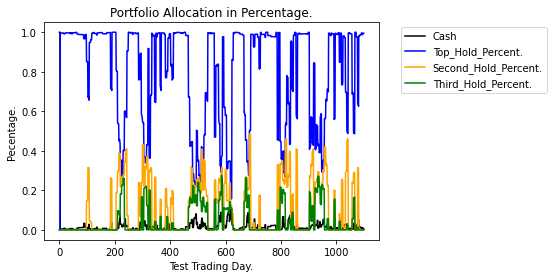

In [14]:
plt.plot(range(1100),data[0,:],color = 'black', label = 'Cash')
plt.plot(range(1100),data[3,:],color = 'Blue', label = 'Top_Hold_Percent.')
plt.plot(range(1100),data[2,:],color = 'orange', label = 'Second_Hold_Percent.')
plt.plot(range(1100),data[1,:],color = 'green', label = 'Third_Hold_Percent.')
plt.xlabel('Test Trading Day.')
plt.ylabel('Pecentage.')
plt.title('Portfolio Allocation in Percentage.')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [15]:
not_invested = (data[1,:] == 0) & (data[2,:] == 0)
print(f'The Markowtiz model was invested in only asset in {round(sum(not_invested)/len(not_invested),3)} of trading days.')

The Markowtiz model was invested in only asset in 0.564 of trading days.


In [16]:
invested = data[:,~not_invested]
invested = invested[[0,3],:]
invested = 1 - np.sum(invested,axis = 0)
average = np.mean(invested)
print(f'At times that the Markowitz model was not invested in one stock only, the other stocks were in total {round(average,3)} of the portfolio.')

At times that the Markowitz model was not invested in one stock only, the other stocks were in total 0.412 of the portfolio.


In [17]:
cash = np.mean(data[0,:])
print(f'Average cash for Marko is {round(cash,3)}.')

Average cash for Marko is 0.019.


In [18]:
data = np.zeros([4,1100])
for day,number in zip(range(1750,2851),range(1100)):
    
    total_valuation = env.record[day]
    
    valuation = env.stonks[:,day]*env.closes[:,day]
    cash = (total_valuation - np.sum(valuation))
    top_three = np.sort(valuation)[-3:]
    
    data[0,number] = cash/total_valuation
    data[1:4,number] = top_three/total_valuation

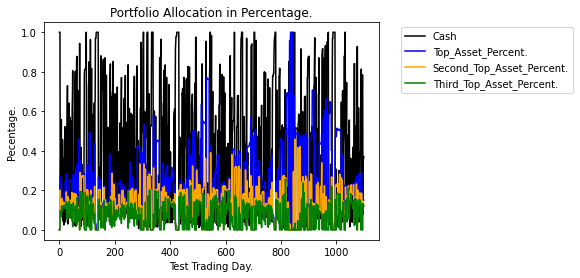

In [19]:
plt.plot(range(1100),data[0,:],color = 'black', label = 'Cash')
plt.plot(range(1100),data[3,:],color = 'Blue', label = 'Top_Asset_Percent.')
plt.plot(range(1100),data[2,:],color = 'orange', label = 'Second_Top_Asset_Percent.')
plt.plot(range(1100),data[1,:],color = 'green', label = 'Third_Top_Asset_Percent.')
plt.xlabel('Test Trading Day.')
plt.ylabel('Pecentage.')
plt.title('Portfolio Allocation in Percentage.')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [20]:
not_invested = (data[1,:] == 0) & (data[2,:] == 0)
print(f'The CASS model was invested in only asset in {round(sum(not_invested)/len(not_invested),3)} of trading days.')

The CASS model was invested in only asset in 0.128 of trading days.


In [21]:
invested = data[:,~not_invested]
invested = invested[[0,3],:]
invested = 1 - np.sum(invested,axis = 0)
average = np.mean(invested)
print(f'At times that the CASS model was not invested in one stock only, the other stocks were in total {round(average,3)} of the portfolio.')

At times that the CASS model was not invested in one stock only, the other stocks were in total 0.366 of the portfolio.


In [22]:
cash = np.mean(data[0,:])
print(f'Average cash for CASS is {round(cash,3)}.')

Average cash for CASS is 0.409.
